In [1]:
import scanpy as sc
import anndata as ann
import numpy as np 
import seaborn as sb
import pandas as pd
import pickle
from sklearn import preprocessing as pp
import diffxpy.api as de
import time
from scipy import sparse

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
from importlib import reload  
import helper
reload(helper)
import helper as h
from constants import SAVE
import expected_multiplet_rate as emr
reload(emr)
import expected_multiplet_rate as emr
#sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
library(scran)
library(biomaRt)
library(BiocParallel)
#library(Seurat)

In [4]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE117770/'
UID2='NOD_elimination_annotation'

Load data:

In [5]:
#Load data
#adata=pickle.load(  open( shared_folder+"data_normalised.pkl", "rb" ) )
adata=h.open_h5ad(shared_folder+"data_normalised.h5ad",unique_id2=UID2)

## Visualisation

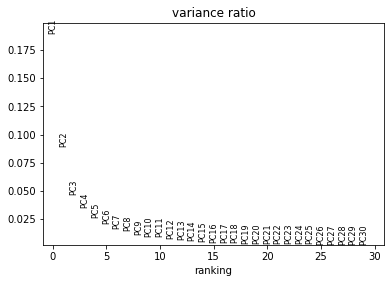

In [6]:
sc.pp.pca(adata, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

In [7]:
# Select number of PCs to use
N_PCS=13

Compare different embeddings based on previously defined annotation. 

In [ ]:
#sc.pp.neighbors(adata,n_pcs = N_PCS,metric='correlation') 
#sc.tl.umap(adata)

In [ ]:
#rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata,size=10,color=['pre_cell_type'])
#sc.pl.umap(adata,size=10,color=['file'])

In [8]:
sc.pp.neighbors(adata,n_pcs = N_PCS) 
sc.tl.umap(adata)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'

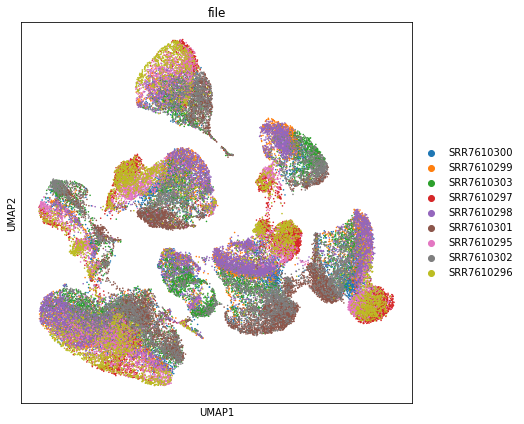

In [9]:
rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata,size=10,color=['pre_cell_type'])
sc.pl.umap(adata,size=10,color=['file'])

#### On scaled data

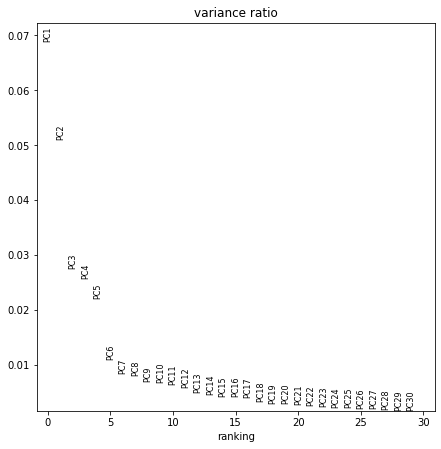

In [10]:
# Scale data and perform PCA
adata_scl=adata.copy()
sc.pp.scale(adata_scl,max_value=10)
sc.pp.pca(adata_scl, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_scl)

In [11]:
#C: Can  not stay the same as above
N_PCS

13

In [12]:
# neighbours on scaled data
sc.pp.neighbors(adata_scl,n_pcs = 20) 

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [13]:
# Umap on scaled data
sc.tl.umap(adata_scl)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


In [14]:
# Add scaled embedding to adata
adata.obsm['X_umap_scl']=adata_scl.obsm['X_umap']

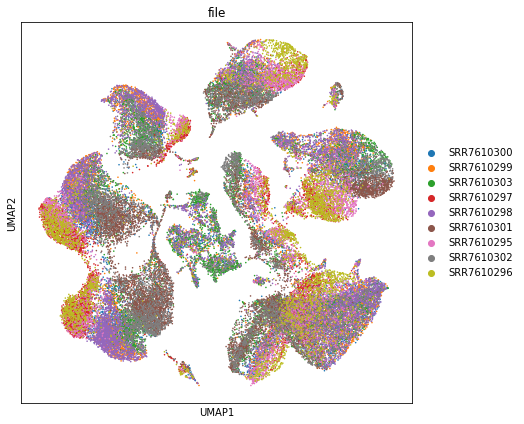

In [15]:
rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata_scl,size=10,color=['pre_cell_type'])
sc.pl.umap(adata_scl,size=10,color=['file'])

## Cell cycle
Performed separately for individual batches.

### Seurat/Scanpy - score by G2M and S

In [16]:
# Load mouse cell cycle genes
cell_cycle_mm=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/cell_cycle_mm_Macosko2015.tsv',sep='\t')

Use cell cycle genes that overlap HVGs (from different batches). Display these genes on HVG plots (with non-phase genes being marked as .NA).

Use G2/M and M gene sets for G2/M annotation and S gene set for S annotation.

G1/S N genes: 92 overlap var: 90 overlap hvg (all): 4
S N genes: 96 overlap var: 95 overlap hvg (all): 5
G2/M N genes: 127 overlap var: 126 overlap hvg (all): 16
M N genes: 143 overlap var: 142 overlap hvg (all): 12
M/G1 N genes: 108 overlap var: 105 overlap hvg (all): 8
N genes for scoring S: 5 and G2/M: 28


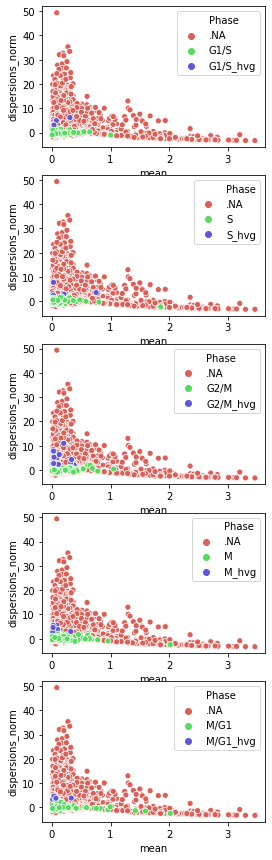

In [17]:
# How many of the cell cycle phase genes are present in HVG and in var and how variable they are
hvg=set(adata.var_names[adata.var.highly_variable])
i=0
rcParams['figure.figsize']=(4,15)
fig,axs=plt.subplots(5)
s_hvg=[]
g2m_hvg=[]
for phase in cell_cycle_mm.Phase.unique():
    genes_phase = set(cell_cycle_mm.query('Phase =="'+phase+'"').Gene)
    overlap_var = set(adata.var_names) & genes_phase
    overlap_hvg = hvg & genes_phase
    print(phase,'N genes:',len(genes_phase),'overlap var:',len(overlap_var),'overlap hvg (all):',len(overlap_hvg))
    phase_df=pd.DataFrame([phase]*len(overlap_var),index=overlap_var,columns=['Phase']).reindex(adata.var_names).fillna('.NA').sort_values('Phase')
    phase_df.loc[overlap_hvg,'Phase']=phase+'_hvg'
    phase_df['mean']=adata.var.means
    phase_df['dispersions_norm']=adata.var.dispersions_norm
    sb.scatterplot(x="mean", y="dispersions_norm", hue="Phase",data=phase_df,ax=axs[i],palette='hls')
    i+=1
    if phase == 'S':
        s_hvg.extend(overlap_hvg)
    if phase in ['G2/M','M']:
        g2m_hvg.extend(overlap_hvg)
        
print('N genes for scoring S:',len(s_hvg),'and G2/M:',len(g2m_hvg))

Cell cycle annotation

In [18]:
# Annotated cell cycle per batch
adata.obs['S_score']= np.zeros(adata.shape[0])
adata.obs['G2M_score'] = np.zeros(adata.shape[0])
adata.obs['phase'] = np.zeros(adata.shape[0])

for batch in enumerate(adata.obs['file'].cat.categories):
    batch=batch[1]
    idx = adata.obs.query('file=="'+batch+'"').index
    adata_tmp = adata[idx,:].copy()
    sc.tl.score_genes_cell_cycle(adata_tmp, s_genes=s_hvg, g2m_genes=g2m_hvg,use_raw=False)
    adata.obs.loc[idx,'S_score'] = adata_tmp.obs['S_score']
    adata.obs.loc[idx,'G2M_score'] = adata_tmp.obs['G2M_score']
    adata.obs.loc[idx,'phase'] = adata_tmp.obs['phase']
    
del adata_tmp

In [19]:
# Count of cells annotated to each phase
adata.obs['phase'].value_counts()

G1     28422
S      17338
G2M     8569
Name: phase, dtype: int64

Display cell cycle score distributions and annotation.

... storing 'phase' as categorical


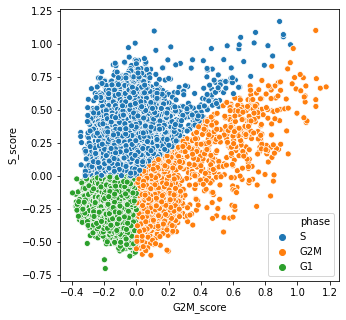

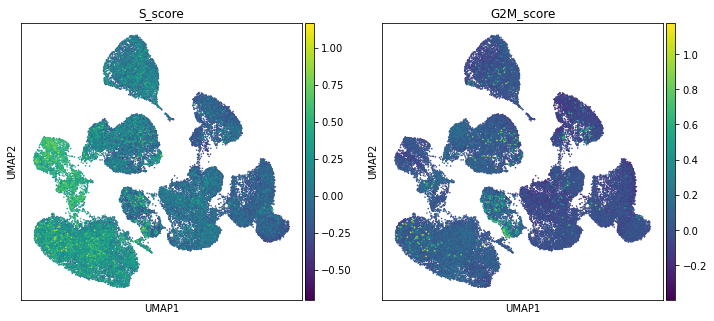

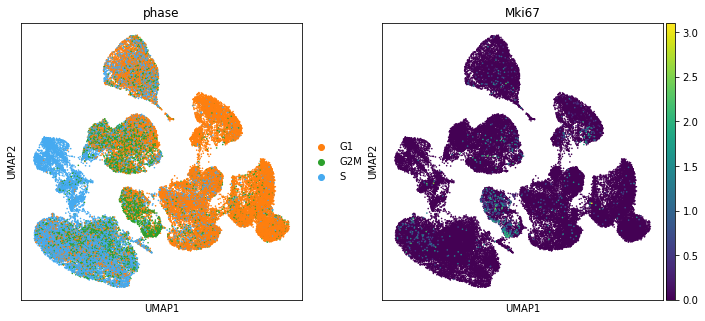

In [20]:
adata.uns['phase_colors']=['#ff7f0e', '#2ca02c','#46aaf0']

rcParams['figure.figsize']=(5,5)
sb.scatterplot(x='G2M_score',y='S_score',hue='phase',data=adata.obs)
sc.pl.umap(adata, color=['S_score', 'G2M_score'], size=10, use_raw=False)
sc.pl.umap(adata, color=['phase','Mki67'], size=10, use_raw=False)

#C: There might seem to be some proliferating populations, but not as many as indicated by the non-cyclone annotation.

 ### Cyclone - based on G1, S, and G2/M scores

Add gene Entrez IDs to adata in order to map genes to cell cycle database.

In [21]:
# Adata genes for R
genes=adata.var_names

#C: Current Ensembl release 101

In [22]:
%%R -i genes -o gene_ids
# Extract Ensembl gene IDs
mouse = useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl",version='Ensembl Genes 101',
                host="https://www.ensembl.org")
gene_ids = getBM(attributes = c("mgi_symbol",'ensembl_gene_id'), 
                 filters = "mgi_symbol", values = genes , mart = mouse, uniqueRows=FALSE)

In [23]:
# Add gene ids to adata, use only genes with unique mapped ensembl ids
gene_ids.drop_duplicates(subset='mgi_symbol', keep=False, inplace=True)
gene_ids.index=gene_ids.mgi_symbol
gene_ids=gene_ids.reindex(list(adata.var_names))
adata.var['EID']=gene_ids.ensembl_gene_id

In [24]:
# Prepare R data for cyclonee
x_mat=adata.X.T
gene_ids=adata.var.EID
batches=adata.obs.file
cells=adata.obs.index

In [25]:
%%R -i x_mat -i gene_ids -i batches -i cells -o cyclone_anno
# Cyclone cell scores, calculated separately for each batch
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))
phases<-c()
s<-c()
g2m<-c()
g1<-c()
cells_order<-c()
for(batch in unique(batches)){
    # Select batch data
    x_mat_batch=x_mat[,batches==batch]
    print(batch,dim(x_mat_batch[1]))
    # Scores
    assignments <- cyclone(x_mat_batch, mm.pairs, gene.names=gene_ids,BPPARAM=MulticoreParam(workers = 16))
    phases<-c(phases,assignments$phases)
    s<-c(s,assignments$score$S)
    g2m<-c(g2m,assignments$score$G2M)
    g1<-c(g1,assignments$score$G1)
    # Save cell order
    cells_order<-c(cells_order,cells[batches==batch])
}
cyclone_anno<-data.frame(phase_cyclone=phases,s_cyclone=s,g2m_cyclone=g2m,g1_cyclone=g1)
rownames(cyclone_anno)<-cells_order

[1] "SRR7610300"
[1] "SRR7610299"
[1] "SRR7610303"
[1] "SRR7610297"
[1] "SRR7610298"
[1] "SRR7610301"
[1] "SRR7610295"
[1] "SRR7610302"
[1] "SRR7610296"


In [26]:
# Count of cells annotated to each phase
cyclone_anno.phase_cyclone.value_counts()

G1     53815
G2M      457
S         57
Name: phase_cyclone, dtype: int64

In [27]:
# Add cyclone annotation to adata
cyclone_anno=cyclone_anno.reindex(adata.obs.index)
adata.obs=pd.concat([adata.obs,cyclone_anno],axis=1)

In [28]:
adata.obs.columns

Index(['file', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter',
       'n_genes_filter', 'mt_frac_filter', 'doublet_score', 'doublet',
       'doublet_score_filter', 'size_factors', 'S_score', 'G2M_score', 'phase',
       'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone'],
      dtype='object')

... storing 'phase_cyclone' as categorical
... storing 'EID' as categorical


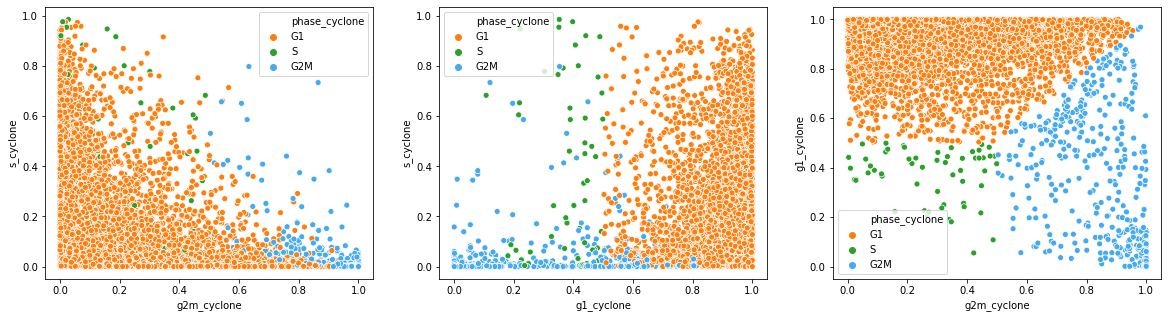

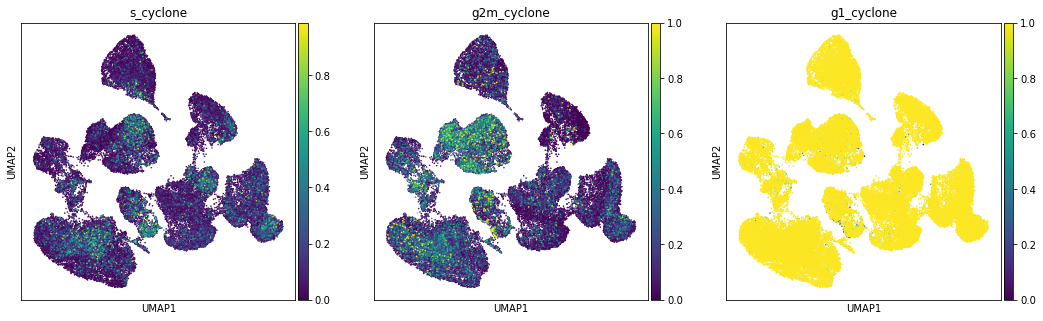

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


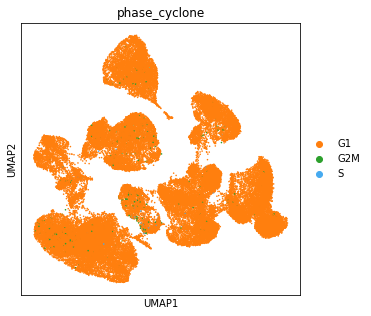

In [29]:
# Plot score distributions and cell assignment on UMAP
rcParams['figure.figsize']=(20,5)
fig,axs=plt.subplots(1,3)
#C: S phase was never annotated - shorten the pallete
palette=sb.color_palette(['#ff7f0e', '#2ca02c','#46aaf0'])
#palette=sb.color_palette(['#ff7f0e', '#2ca02c'])
sb.scatterplot(x='g2m_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[0],palette=palette)
sb.scatterplot(x='g1_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[1],palette=palette)
sb.scatterplot(x='g2m_cyclone',y='g1_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[2],palette=palette)
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['s_cyclone', 'g2m_cyclone','g1_cyclone'], size=10, use_raw=False)
adata.uns['phase_cyclone_colors']=palette
sc.pl.umap(adata, color=['phase_cyclone'], size=10, use_raw=False)

#C: The cyclone results seem more reliable based on Mki67 expression (above).

## Save intermediate results before cell type annotation

In [30]:
if SAVE:
    h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)

# Cell type annotation

In [5]:
adata=h.open_h5ad(shared_folder+"data_annotated.h5ad",unique_id2=UID2)

## Endo high annotation

In [6]:
# Normalise raw data for cell type scoring
adata_rawnorm=adata.raw.to_adata().copy()
adata_rawnorm.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata_rawnorm)
adata_rawnorm.X = np.asarray(adata_rawnorm.X)
adata_rawnorm.obs=adata.obs.copy()

#### Ins

In [7]:
# Compute Ins score
sc.tl.score_genes(adata_rawnorm, gene_list=['Ins1','Ins2'], score_name='ins_score',  use_raw=False)

<ipython-input-14-cab345d1d34c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_scores['ins_score_norm']=pp.minmax_scale(ins_scores.ins_score)


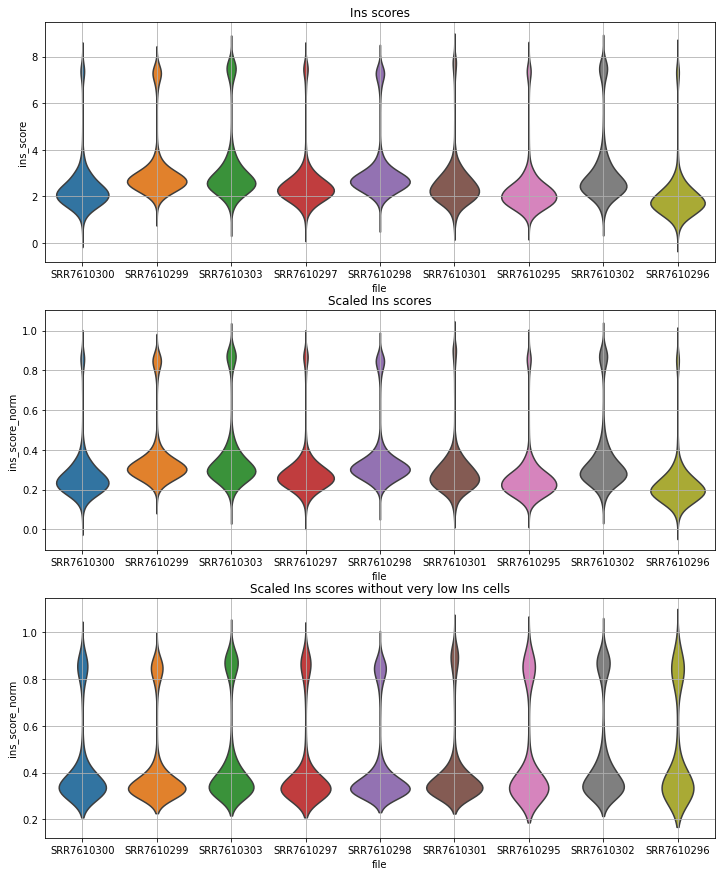

In [14]:
#sc.pl.violin(adata_rawnorm, keys=['ins_score'], groupby='file', stripplot=False, jitter=True)
ins_scores=adata_rawnorm.obs[['ins_score','file']]
ins_scores['ins_score_norm']=pp.minmax_scale(ins_scores.ins_score)
rcParams['figure.figsize']=(12,15)
fig,axs=plt.subplots(3,1)
sb.violinplot(x='file',y='ins_score',data=ins_scores,inner=None,ax=axs[0])
axs[0].title.set_text('Ins scores')
axs[0].grid()
sb.violinplot(x='file',y='ins_score_norm',data=ins_scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled Ins scores')
axs[1].grid()
sb.violinplot(x='file',y='ins_score_norm',data=ins_scores[ins_scores.ins_score_norm>0.3],inner=None,ax=axs[2])
axs[2].title.set_text('Scaled Ins scores without very low Ins cells')
axs[2].grid()

In [16]:
# Find ins high cells
adata_rawnorm.obs['ins_high']=ins_scores.ins_score_norm>0.65
print('Proportion of ins high across samples:')
adata_rawnorm.obs[['file','ins_high']].groupby('file').ins_high.value_counts(normalize=True,sort=False)

Proportion of ins high across samples:


file        ins_high
SRR7610300  False       0.955594
            True        0.044406
SRR7610299  False       0.895391
            True        0.104609
SRR7610303  False       0.879102
            True        0.120898
SRR7610297  False       0.947470
            True        0.052530
SRR7610298  False       0.897516
            True        0.102484
SRR7610301  False       0.955447
            True        0.044553
SRR7610295  False       0.955747
            True        0.044253
SRR7610302  False       0.890949
            True        0.109051
SRR7610296  False       0.966805
            True        0.033195
Name: ins_high, dtype: float64

In [15]:
# Add info about ins high to main adata and save it
adata.obs['ins_score']=adata_rawnorm.obs['ins_score']
adata.obs['ins_high']=adata_rawnorm.obs['ins_high']

#### Gcg

In [7]:
genes=['Gcg']
score_name='gcg'

In [8]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-9-458a9266293c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


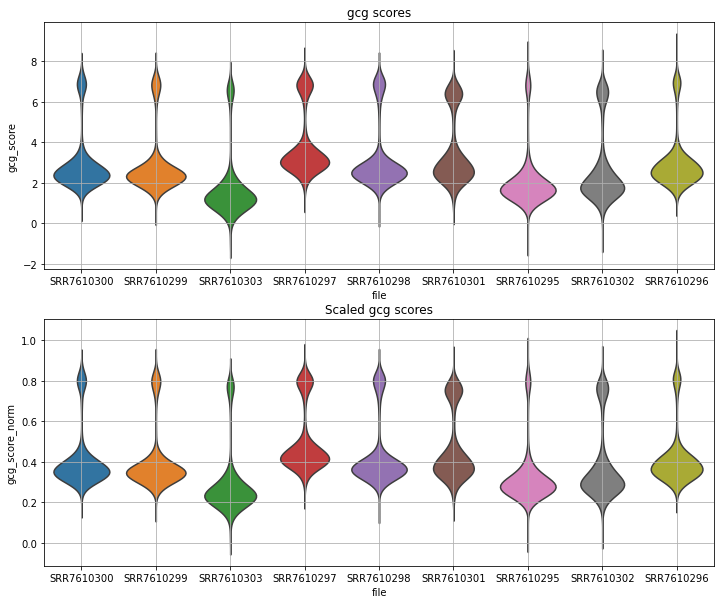

In [9]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(12,10)
fig,axs=plt.subplots(2,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
#sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.15],
#             inner=None,ax=axs[2])
#axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
#axs[2].grid()

In [12]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'SRR7610300':0.65,'SRR7610299':0.65,'SRR7610303':0.6,'SRR7610297':0.65,'SRR7610298':0.65,
 'SRR7610301':0.6,'SRR7610295':0.65,'SRR7610302':0.6,'SRR7610296':0.65}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of gcg high across samples:


file        gcg_high
SRR7610300  False       0.878925
            True        0.121075
SRR7610299  False       0.874980
            True        0.125020
SRR7610303  False       0.904555
            True        0.095445
SRR7610297  False       0.782348
            True        0.217652
SRR7610298  False       0.831104
            True        0.168896
SRR7610301  False       0.754098
            True        0.245902
SRR7610295  False       0.929113
            True        0.070887
SRR7610302  False       0.823480
            True        0.176520
SRR7610296  False       0.898801
            True        0.101199
Name: gcg_high, dtype: float64

In [13]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

In [ ]:
#### SSt

In [14]:
genes=['Sst']
score_name='sst'

In [15]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-16-458a9266293c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


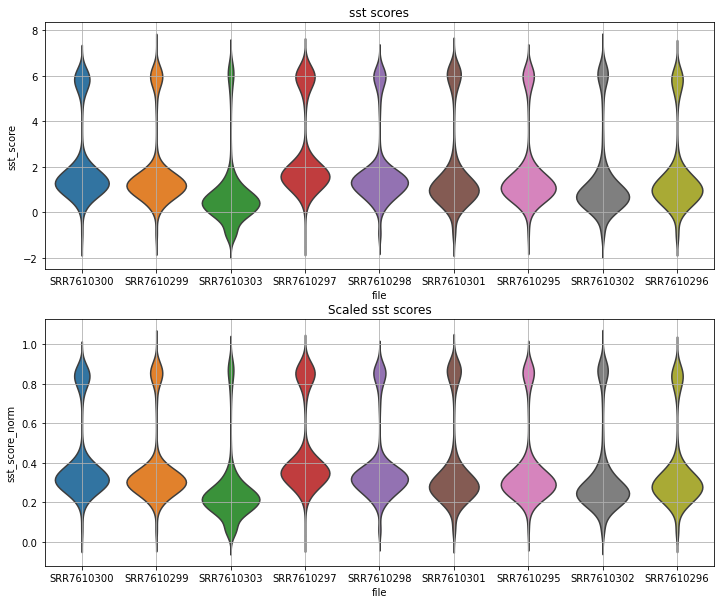

In [16]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(12,10)
fig,axs=plt.subplots(2,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
#sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.15],
#             inner=None,ax=axs[2])
#axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
#axs[2].grid()

In [17]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'SRR7610300':0.65,'SRR7610299':0.65,'SRR7610303':0.65,'SRR7610297':0.65,'SRR7610298':0.65,
 'SRR7610301':0.65,'SRR7610295':0.65,'SRR7610302':0.65,'SRR7610296':0.65}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of sst high across samples:


file        sst_high
SRR7610300  False       0.811275
            True        0.188725
SRR7610299  False       0.852815
            True        0.147185
SRR7610303  False       0.922472
            True        0.077528
SRR7610297  False       0.748358
            True        0.251642
SRR7610298  False       0.854276
            True        0.145724
SRR7610301  False       0.818747
            True        0.181253
SRR7610295  False       0.859455
            True        0.140545
SRR7610302  False       0.865397
            True        0.134603
SRR7610296  False       0.847395
            True        0.152605
Name: sst_high, dtype: float64

In [18]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

In [ ]:
#### Ppy

In [19]:
genes=['Ppy']
score_name='ppy'

In [20]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-23-18370387c985>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


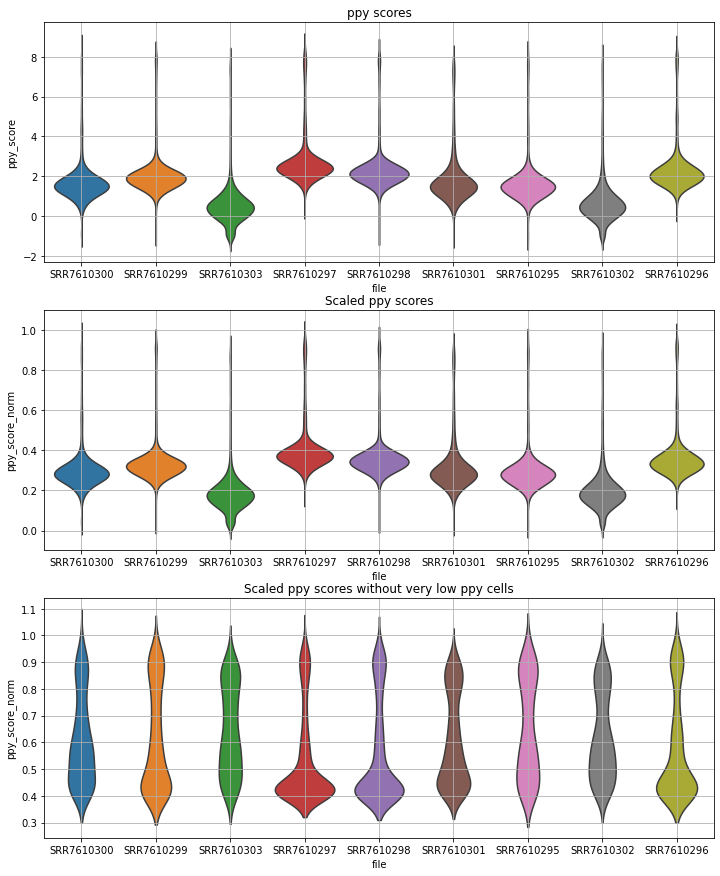

In [23]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(12,15)
fig,axs=plt.subplots(3,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.4],
             inner=None,ax=axs[2])
axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
axs[2].grid()

In [24]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'SRR7610300':0.75,'SRR7610299':0.75,'SRR7610303':0.7,'SRR7610297':0.75,'SRR7610298':0.75,
 'SRR7610301':0.75,'SRR7610295':0.7,'SRR7610302':0.7,'SRR7610296':0.75}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of ppy high across samples:


file        ppy_high
SRR7610300  False       0.981787
            True        0.018213
SRR7610299  False       0.972413
            True        0.027587
SRR7610303  False       0.982083
            True        0.017917
SRR7610297  False       0.943414
            True        0.056586
SRR7610298  False       0.964883
            True        0.035117
SRR7610301  False       0.963776
            True        0.036224
SRR7610295  False       0.973161
            True        0.026839
SRR7610302  False       0.981630
            True        0.018370
SRR7610296  False       0.963347
            True        0.036653
Name: ppy_high, dtype: float64

In [25]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

In [26]:
#### Save

In [27]:
if SAVE:
    h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)